## Object Detection Lab Overview
This lab guides you through the essentials of object detection and culminates with a YOLOv8 demo on a bundled sample image located at `data/sample_image.jpeg`.

What you will practice:
- Drawing custom bounding boxes on the provided sample image to build intuition about coordinates.
- Calculating Intersection-over-Union (IoU) step by step before trusting library helpers.
- Downloading and running a pre-trained YOLOv8 nano model from Hugging Face to visualize detections.

Tip: run the notebook sequentially the first time so cached assets (like the YOLO weights) are downloaded only once.

### Setup roadmap
Before diving into the exercises, make sure you:
1. Run `uv sync` (or `uv add <pkg>`) so `huggingface_hub`, `ultralytics`, and `opencv-python` are present.
2. Execute the environment check cell below once per fresh kernel to confirm imports and OpenCV bindings.
3. Keep `data/sample_image.jpeg` in place—the first visualization cell depends on it.
After these steps, work through the exercises in order; each one builds on the state from the previous cells.

In [1]:
import importlib
import importlib.util
import sys
from pathlib import Path

REQUIRED_IMPORTS = {
    "huggingface_hub": "huggingface_hub",
    "ultralytics": "ultralytics",
}


def ensure_cv2_available() -> None:
    try:
        import cv2  # noqa: F401
        if hasattr(cv2, "imshow"):
            return
    except ModuleNotFoundError:
        cv2 = None  # type: ignore

    site_packages = (
        Path(sys.executable).resolve().parent.parent
        / "lib"
        / f"python{sys.version_info.major}.{sys.version_info.minor}"
        / "site-packages"
        / "cv2"
        / "__init__.py"
    )
    if site_packages.exists():
        spec = importlib.util.spec_from_file_location("cv2", site_packages)
        module = importlib.util.module_from_spec(spec)
        sys.modules["cv2"] = module
        if spec.loader is None:
            raise ImportError("cv2 spec loader missing; cannot initialize OpenCV module")
        spec.loader.exec_module(module)

    import cv2  # noqa: F401
    if not hasattr(cv2, "imshow"):
        raise ImportError(
            "OpenCV is installed but missing GUI bindings. Reinstall `opencv-python` in the project environment."
        )


missing = []
for display_name, import_name in REQUIRED_IMPORTS.items():
    if import_name == "ultralytics":
        ensure_cv2_available()
    try:
        importlib.import_module(import_name)
    except ModuleNotFoundError:
        missing.append(display_name)

if missing:
    raise ModuleNotFoundError(
        "Missing packages: " + ", ".join(missing) + "\n"
        "Install them via `uv add <package>` or `uv sync` before running the rest of the notebook."
    )

print("All required packages found. Continue with the next cell.")

All required packages found. Continue with the next cell.


Project root: /Users/mishra/LM/projects/computer-vision-cas-hslu-2025
Sample image path: /Users/mishra/LM/projects/computer-vision-cas-hslu-2025/data/sample_image.jpeg


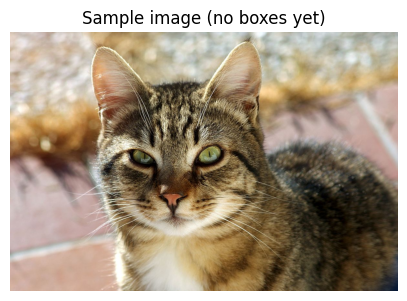

In [2]:
from pathlib import Path
import sys

import torch
from torchvision.io import read_image


def _find_repo_root(start: Path) -> Path:
    for path in [start, *start.parents]:
        if (path / "src" / "cvcourse").exists():
            return path
    raise RuntimeError("Could not locate project root containing src/cvcourse")


PROJECT_ROOT = _find_repo_root(Path.cwd())
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

from cvcourse.utils.paths import get_data_dir
from cvcourse.viz.images import show_image
from cvcourse.viz.bounding_boxes import draw_bounding_boxes_on_image, box_iou


data_dir = get_data_dir()
sample_image_path = data_dir / "sample_image.jpeg"
if not sample_image_path.exists():
    raise FileNotFoundError(f"Expected sample image at {sample_image_path}")

sample_image_tensor = read_image(str(sample_image_path)).float() / 255.0

print(f"Project root: {PROJECT_ROOT}")
print(f"Sample image path: {sample_image_path}")
show_image(sample_image_tensor, title="Sample image (no boxes yet)")

### Exercise 1 – draw your own boxes

Update the coordinates in the next cell to mimic hand-drawn bounding boxes on the sample image. Coordinates use `[x1, y1, x2, y2]` pixel format with `(0, 0)` at the top-left corner.

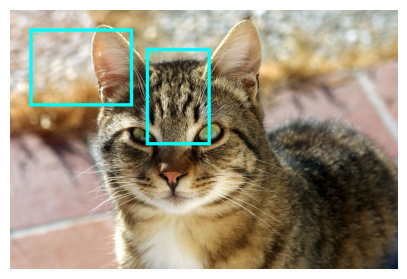

In [3]:
# Edit the coordinates and labels below to experiment.
user_boxes_data = [
    [60, 60, 380, 300],
    [420, 120, 620, 420],
]
user_labels = ["object-1", "object-2"]

if not user_boxes_data:
    raise ValueError("Add at least one box inside user_boxes_data.")

user_boxes = torch.tensor(user_boxes_data, dtype=torch.float32)
labels = user_labels or [f"user-box-{idx + 1}" for idx in range(len(user_boxes_data))]

draw_bounding_boxes_on_image(sample_image_tensor.clone(), user_boxes, labels=labels)

### Exercise 2 – IoU metrics from scratch
Adjust the prediction box, rerun, and interpret both the numeric IoU plus the visualization overlay:
- The console output shows intersection, union, and IoU so you can sanity-check the math.
- The plot overlays the ground-truth box (green) and your prediction (orange) on the sample image.
Tweak the coordinates repeatedly until the visual overlap matches the IoU intuition you expect.

Intersection area: 72000.00 pixels^2
Union area:         109400.00 pixels^2
IoU ratio:          0.658


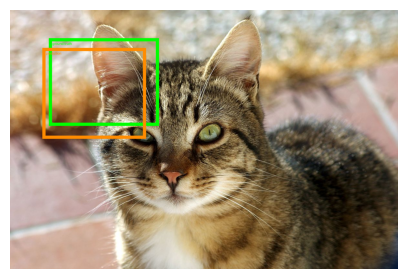

In [4]:
ground_truth_box = torch.tensor([120.0, 90.0, 460.0, 360.0])
prediction_box = torch.tensor([100.0, 120.0, 420.0, 400.0])  # <-- edit this line

x1 = torch.max(ground_truth_box[0], prediction_box[0])
y1 = torch.max(ground_truth_box[1], prediction_box[1])
x2 = torch.min(ground_truth_box[2], prediction_box[2])
y2 = torch.min(ground_truth_box[3], prediction_box[3])

inter_width = torch.clamp(x2 - x1, min=0.0)
inter_height = torch.clamp(y2 - y1, min=0.0)
intersection_area = inter_width * inter_height

gt_area = (ground_truth_box[2] - ground_truth_box[0]) * (ground_truth_box[3] - ground_truth_box[1])
pred_area = (prediction_box[2] - prediction_box[0]) * (prediction_box[3] - prediction_box[1])
union_area = gt_area + pred_area - intersection_area

iou_value = float(box_iou(prediction_box, ground_truth_box))

print(f"Intersection area: {intersection_area:.2f} pixels^2")
print(f"Union area:         {union_area:.2f} pixels^2")
print(f"IoU ratio:          {iou_value:.3f}")

overlay_boxes = torch.stack([ground_truth_box, prediction_box])
overlay_labels = ["ground truth", "prediction"]
overlay_colors = ["lime", "darkorange"]
draw_bounding_boxes_on_image(
    sample_image_tensor.clone(),
    overlay_boxes,
    labels=overlay_labels,
    colors=overlay_colors,
)

### Exercise 3 – run YOLOv8 from Hugging Face

This final cell downloads the `Ultralytics/YOLOv8` weights (nano variant), loads them with the `ultralytics` Python API, and overlays detections on `sample_image.jpeg`. Rerun it if you tweak thresholds or switch to a different model file.

Detections above threshold: 1


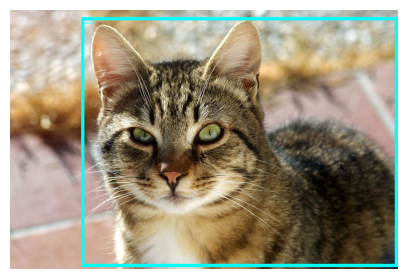

In [5]:
from huggingface_hub import hf_hub_download
from ultralytics import YOLO

YOLO_REPO_ID = "Ultralytics/YOLOv8"
YOLO_FILENAME = "yolov8n.pt"

weights_path = hf_hub_download(repo_id=YOLO_REPO_ID, filename=YOLO_FILENAME)
model = YOLO(weights_path)

results = model.predict(
    source=str(sample_image_path),
    conf=0.35,
    iou=0.5,
    imgsz=640,
    verbose=False,
    device="cpu",
)

if not results:
    raise RuntimeError("YOLO returned no results; ensure the model ran successfully.")

prediction = results[0]
if prediction.boxes is None or prediction.boxes.xyxy.numel() == 0:
    print("YOLOv8 did not produce any boxes above the confidence threshold.")
else:
    boxes_xyxy = prediction.boxes.xyxy.cpu()
    confidences = prediction.boxes.conf.cpu()
    class_ids = prediction.boxes.cls.cpu().int()

    names = model.names
    if not isinstance(names, dict):
        names = {idx: name for idx, name in enumerate(names)}

    labels = [
        f"{names.get(int(cls_id), f'class-{int(cls_id)}')} {conf:.2f}"
        for cls_id, conf in zip(class_ids, confidences)
    ]

    print(f"Detections above threshold: {len(labels)}")
    draw_bounding_boxes_on_image(
        sample_image_tensor.clone(),
        boxes_xyxy,
        labels=labels,
    )

In [6]:
# try on other images from other datasets

In [7]:
# What happens when you try images with multiple instances of the same object class?

In [8]:
# Find failure modes for object detections